In [321]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
import pandas as pd
import math
from scipy.optimize import curve_fit
from scipy.stats import chisquare

%matplotlib inline
plt.style.use('tableau-colorblind10')
#plt.style.use('ggplot')

In [322]:
#=====================================
# Load txt file to pandas dataframe
#=====================================
data_raw = pd.read_csv('mu-g4.txt', sep='\t', names=['tdc11', 'tdc12', 'tdc13', 'tdc14', 'tdc15', 'tdc16', 'tdc17', 'tdc18',
                                                        'tdc21', 'tdc22', 'tdc23', 'tdc24', 'tdc25', 'tdc26', 'tdc27', 'tdc28',
                                                       ])
data_raw = data_raw.rename(columns={'tdc11' : 'p0_1',
                            'tdc12' : 'p1_1',
                            'tdc13' : 'p2_1',
                            'tdc14' : 'start2',
                            'tdc24' : 'p0_2',
                            'tdc25' : 'p1_2',
                            'tdc26' : 'p2_2',
                            'tdc23' : 'stop2',
                           })
print('Total number of events:', len(data_raw))
#data_raw.head()

Total number of events: 1014917


In [323]:
# keeps only necessary

data = data_raw[['p0_1','p1_1','p2_1','start2','p0_2','p1_2','p2_2','stop2']]
#data.head()

In [324]:
# loads fitted parameters from parameters.txt

par=pd.read_csv('parameters.txt', sep=' ', names=['tdc','a','b'])
df_par=par.set_index('tdc')
#df_par.head()

In [325]:
#=====================================
# Convert tdc units into ns
#=====================================
def tdc_to_ns(channel, tdc_unit):
    ns = (tdc_unit - df_par.loc[channel, 'b']) / df_par.loc[channel, 'a']
    return ns

#=====================================
# Only one valide time for each detector
#=====================================
def merge_time(d,number):
    if (d['p%i_1'%(number)]==4095):
        return d['p%i_2_ns'%(number)]
    else:
        return d['p%i_1_ns'%(number)]
    
#=====================================
# Add actual time variables to the dataframe
#=====================================
def conv_time(d):
    d['start2_ns'] = tdc_to_ns('tdc14', d.start2)
    d['p0_1_ns'] = tdc_to_ns('tdc11', d.p0_1)
    d['p1_1_ns'] = tdc_to_ns('tdc12', d.p1_1)
    d['p2_1_ns'] = tdc_to_ns('tdc13', d.p2_1)
    d['p0_2_ns'] = tdc_to_ns('tdc24', d.p0_2) + d.start2_ns
    d['p1_2_ns'] = tdc_to_ns('tdc25', d.p1_2) + d.start2_ns
    d['p2_2_ns'] = tdc_to_ns('tdc26', d.p2_2) + d.start2_ns
    
    d['p0_time'] = d.apply(lambda d: merge_time(d,0),axis=1)
    d['p1_time'] = d.apply(lambda d: merge_time(d,1),axis=1)
    d['p2_time'] = d.apply(lambda d: merge_time(d,2),axis=1)
    return d

In [544]:
#=====================================
# Data selection cuts
#=====================================

# eventi sui singoli piani
def cut_p0(data):
    cut = ((data.p0_1!=4095) | (data.p0_2!=4095)) & ((data.p1_1==4095) & (data.p1_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p0 = data[cut]
    #p0 = p0.rename(columns={'p0_1': 'time_tdc1', 'p0_2': 'time_tdc2'})
    #p0 = p0[['tdc1','tdc2']]
    return p0

def cut_p1(data):
    cut = ((data.p1_1!=4095) | (data.p1_2!=4095)) & ((data.p0_1==4095) & (data.p0_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p1 = data[cut]
    #p1 = p1.rename(columns={'p1_1': 'time_tdc1', 'p1_2': 'time_tdc2'})
    #p1 = p1[['tdc1','tdc2']]
    return p1

def cut_p2(data):
    cut = (((data.p2_1!=4095) | (data.p2_2!=4095)) & (data.p1_1==4095) & (data.p1_2==4095)  & (data.p0_1==4095) & (data.p0_2==4095))
    p2 = data[cut]
    #p2 = p2.rename(columns={'p2_1': 'time_tdc1', 'p2_2': 'time_tdc2'})
    #p2 = p2[['tdc1','tdc2']]
    return p2

# buoni
def one_and_zero(d):
    p_ms = d[((d.p0_1!=4095)|(d.p0_2!=4095)) & ((d.p1_1!=4095)|(d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095)]
    p_ms = p_ms['p1_time'] #1
    p_ms = p_ms.rename(columns={'p1_time':'time'}) #1
    #p_ms0 = p_ms['p0_time']
    #p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    #p_me = pd.concat([p_ms1,p_ms0])
    return p_ms

def soft_cut(d):
    p_one_and_zero = one_and_zero(d)
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_one_and_zero,p2])
    return p_me

def soft_cut_plus_one(d):
    p_one_and_zero = one_and_zero(d)
    p1 = cut_p1(d)
    p1 = p1['p1_time']
    p1 = p1.rename(columns={'p1_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_one_and_zero,p1,p2])
    return p_me

def hard_cut(d):
    p_ms = d[((d.p0_1!=4095)|(d.p0_2!=4095)) & ((d.p1_1!=4095)|(d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095) & (d.p1_time<d.p0_time)]
    p_ms = p_ms['p1_time']
    p_ms = p_ms.rename(columns={'p1_time':'time'})
    #p_ms0 = p_ms['p0_time']
    #p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_ms,p2])
    return p_me


In [517]:
#=====================================
# Functions to fit
#=====================================

def simple_expo (x, c, tau, d):
    return c*np.exp(-x/tau)+d

def simple_expo_norm (x, c, tau, d):
    return (c/tau)*np.exp(-x/tau)+d

def complex_expo (x, a, tau_n, c, tau_p, d):
    return a*np.exp(-x/tau_n)+c*np.exp(-x/tau_p)+d

def complex_expo_norm (x, a, tau_n, c, tau_p, d):
    return (a/tau_n)*np.exp(-x/tau_n)+(c/tau_p)*np.exp(-x/tau_p)+d

def complex_expo_fixed (x, a, tau_n, c, d):
    return a*np.exp(-x/tau_n)+c*np.exp(-x/2197)+d

In [550]:
#=====================================
# Apply first selection and add time variables to main dataframe
#=====================================

data_used = data[(data.p0_1!=4095) | (data.p0_2!=4095) | (data.p1_1!=4095) | (data.p1_2!=4095) | (data.p2_1!=4095) | (data.p2_2!=4095)]
data_used = conv_time(data_used)
print('Total numer of triggers:', len(data))
print('Total numer of valid events:', len(data_used))
#data_used.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Total numer of triggers: 1014917
Total numer of valid events: 14976


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


P0 events: 526
[ 38.31797332 241.92598559   4.30183373]
[[ 1.09891540e+01 -7.10338461e+01  1.78738293e-02]
 [-7.10338461e+01  8.53274000e+02 -1.73946730e+00]
 [ 1.78738293e-02 -1.73946730e+00  6.41256783e-02]]


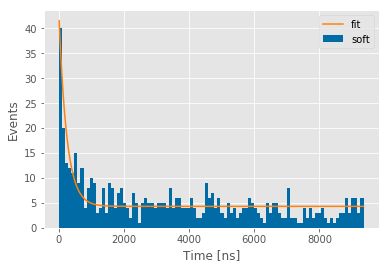

In [221]:
# INUTILE
# esegue taglio piano 0 
p0 = cut_p0(data_used)
p0 = p0['p0_time']
print('P0 events:', len(p0))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p0, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P1 events: 11732
[1269.43921581  914.18000357   -5.57766572]
[[10479.57009158 -7638.13225457    29.22419172]
 [-7638.13225457 13912.78845254 -1161.67782566]
 [   29.22419172 -1161.67782566   396.08313407]]


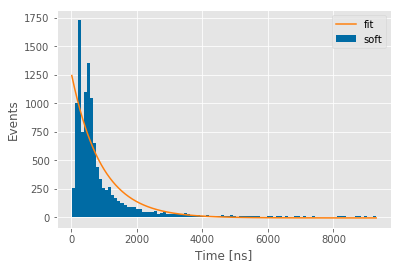

In [222]:
# INUTILE
# esegue taglio piano 1
p1 = cut_p1(data_used)
p1 = p1['p1_time']
print('P1 events:', len(p1))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p1, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P2 events: 1579
P2_fit events: 1050
[  39.23911669 2129.93752357    4.24706215]
[[ 1.20176807e+01 -8.10058400e+02  1.32709799e+00]
 [-8.10058400e+02  8.17689257e+04 -1.98173793e+02]
 [ 1.32709799e+00 -1.98173793e+02  6.89066533e-01]]
285.95266345201975
Power_divergenceResult(statistic=283.9705142975304, pvalue=9.154936680509553e-20)
2.9275310752322725


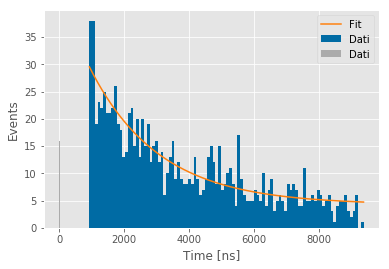

In [329]:
# UTILE
# esegue taglio piano 2
p2 = cut_p2(data_used)
p2 = p2['p2_time']
p2_fit = p2[(p2>935)&(p2<9800)]
print('P2 events:', len(p2))
print('P2_fit events:', len(p2_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p2_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(simple_expo(p2_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)

plt.legend()
plt.show()

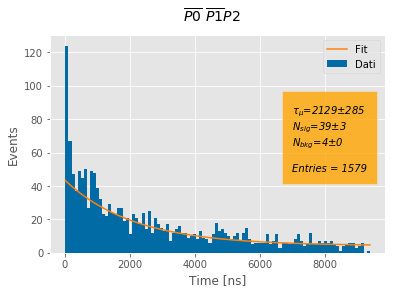

In [224]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
bin_heights, bin_borders, _ = plt.hist(p2, bins=100, label='Dati')
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p2)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/piano2.png')
plt.suptitle('$\overline{P0}$ $\overline{P1} P2$', fontsize=14, fontweight='bold')
plt.show()

P events: 709
P_fit events: 402
[4.04812343e+01 2.16008510e+03 8.02221225e-01]
[[ 1.58498959e+01 -1.13509917e+03  2.12053999e+00]
 [-1.13509917e+03  1.31911190e+05 -3.72805974e+02]
 [ 2.12053999e+00 -3.72805974e+02  1.42754773e+00]]
363.1958018501217
Power_divergenceResult(statistic=307.7963952713953, pvalue=3.4188846668971864e-39)
6.5488594738594745


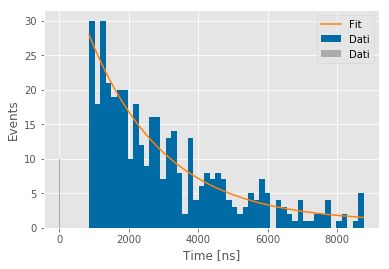

In [316]:
# UTILE
# esegue taglio piano 0 & 1 & not(2)
p_one_and_zero = one_and_zero(data_used)
p_one_and_zero_fit = p_one_and_zero[(p_one_and_zero>860)&(p_one_and_zero<9000)]
print('P events:', len(p_one_and_zero))
print('P_fit events:', len(p_one_and_zero_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_one_and_zero_fit, bins=50, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[200.,2100.,10.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(simple_expo(p_one_and_zero_fit, *popt), bins=50, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)

plt.legend()
plt.show()

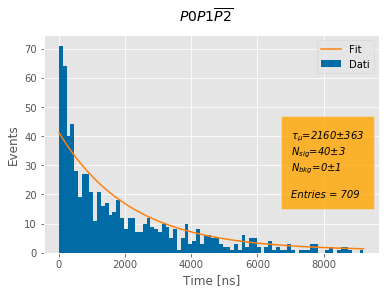

In [226]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
bin_heights, bin_borders, _ = plt.hist(p_one_and_zero, bins=80, label='Dati')
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 20, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_one_and_zero)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/piano0&1.png')
plt.suptitle('$P0 P1 \overline{P2}$', fontsize=14, fontweight='bold')
plt.show()

Events: 2288
Events_fit: 1458
[1.31785516e+05 2.15422247e+03 4.55286128e+00]
[[ 6.22886735e+07  1.30496987e+06 -6.80320874e+03]
 [ 1.30496987e+06  4.37657087e+04 -1.68507485e+02]
 [-6.80320874e+03 -1.68507485e+02  9.25867143e-01]]
209.20255418439723
Power_divergenceResult(statistic=371.6554886820724, pvalue=3.4694215248275766e-33)
3.831499883320334


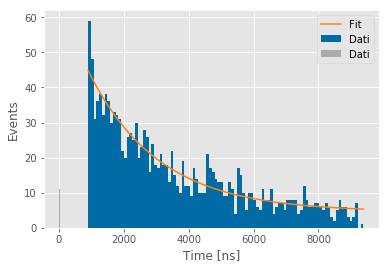

In [330]:
##########################
# UTILE
# esegue taglio: taglio soft senza piano uno
p_merged = soft_cut(data_used)
p_merged_fit = p_merged[(p_merged>900)&(p_merged<9700)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo_norm, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo_norm(x_interval_for_fit, *popt), label='Fit')


bin_heights_fit, bin_borders_fit, _fit = plt.hist(simple_expo_norm(p_merged_fit, *popt), bins=100, label='Dati')
chi = chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)


plt.legend()
plt.show()

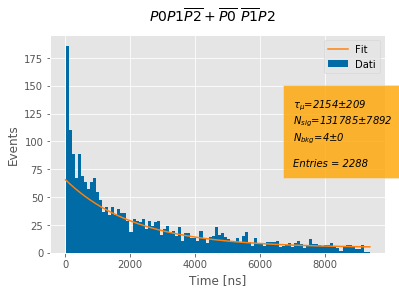

In [331]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
bin_heights, bin_borders, _ = plt.hist(p_merged, bins=100, label='Dati')
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo_norm(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 80, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
#plt.savefig('../tesina/plots/soft_nopiano1.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 1930
Events_fit: 1206
[  44.98512979 2122.77199555    5.09371716]
[[ 1.77809914e+01 -1.02296361e+03  1.92936664e+00]
 [-1.02296361e+03  8.49354970e+04 -2.30396085e+02]
 [ 1.92936664e+00 -2.30396085e+02  8.93607800e-01]]
291.4369520805693
Power_divergenceResult(statistic=263.3483683519492, pvalue=7.397687134943507e-17)
2.714931632494322


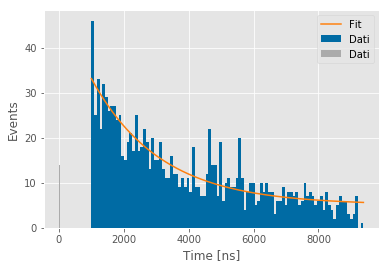

In [318]:
# UTILE
# esegue taglio: taglio hard senza piano uno
p_merged = hard_cut(data_used)
p_merged_fit = p_merged[(p_merged>1000)&(p_merged<10000)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(simple_expo(p_merged_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)


plt.legend()
plt.show()

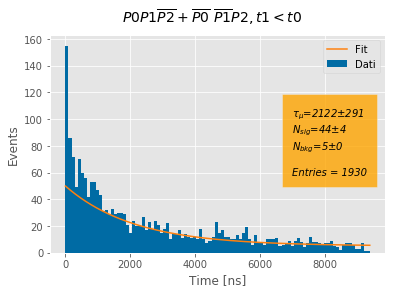

In [230]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
bin_heights, bin_borders, _ = plt.hist(p_merged, bins=100, label='Dati')
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 60, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/hard_nopiano1.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2, t1<t0 $', fontsize=14, fontweight='bold')
plt.show()

Events: 2288
Events_fit: 2199
[  60.31174301  326.55435945   62.54584597 2130.31075099    5.34588218]
[[ 8.18373080e+01  3.18067465e+02 -5.53536727e+01  2.48429806e+03
  -8.12658844e+00]
 [ 3.18067465e+02  8.81918808e+03 -7.01944227e+02  2.59331320e+04
  -7.47137754e+01]
 [-5.53536727e+01 -7.01944227e+02  7.30728321e+01 -2.84162348e+03
   7.99672300e+00]
 [ 2.48429806e+03  2.59331320e+04 -2.84162348e+03  1.40372183e+05
  -5.06212123e+02]
 [-8.12658844e+00 -7.47137754e+01  7.99672300e+00 -5.06212123e+02
   2.44104842e+00]]
93.91053230708256
374.6627594242906
Power_divergenceResult(statistic=276.92732517140445, pvalue=9.281983865797767e-19)
2.915024475488468
385.6741774973572
71.21257591563624


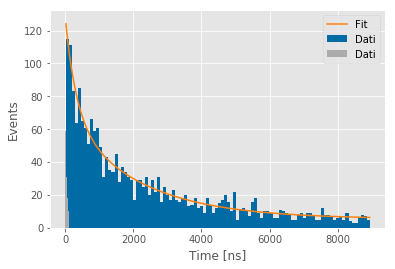

In [636]:
# UTILE
# esegue taglio: taglio soft senza piano uno DOPPIO ESPONENZIALE
p_merged = soft_cut(data_used)
p_merged_fit = p_merged[(p_merged>19.)&(p_merged<9000)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(complex_expo, bin_centers, bin_heights, p0=[100.,265.,86.,2197.,5.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))
print(np.sqrt(pcov.item(3,3)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(complex_expo(p_merged_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)

print(popt[1]*popt[3]/(popt[3]-popt[1]))
print(np.sqrt((pcov.item(1,1)/popt[1])**2+(pcov.item(3,3)/popt[3])**2))


plt.legend()
plt.show()

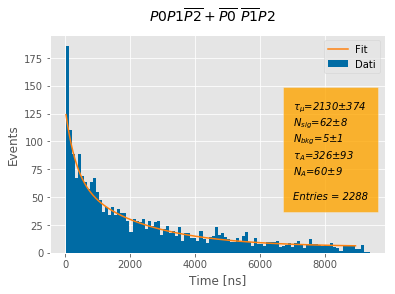

In [637]:
# grafico fit mozzato        N_A,tau_A,N_sig,tau_mu,N_bkg
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i\n' r'$\tau_{A} $' '=%i$\pm$%i''\n$N_{A}$' '=%i$\pm$%i''\n\nEntries = %i'%(popt[3],np.sqrt(pcov.item((3,3))),popt[2],np.sqrt(pcov.item((2,2))),popt[4],np.sqrt(pcov.item((4,4))),popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/soft_doubleexp.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 2288
Events_fit: 2212
[ 64.5304923  333.29327439  65.23954483   5.00952017]
[[ 3.81457648e+01 -1.38443060e+02 -4.82982300e+00  7.87006085e-01]
 [-1.38443060e+02  3.66361021e+03 -1.65317579e+02  1.72439237e+01]
 [-4.82982300e+00 -1.65317579e+02  1.50716537e+01 -2.15249779e+00]
 [ 7.87006085e-01  1.72439237e+01 -2.15249779e+00  5.91283947e-01]]
60.52776397546379
Power_divergenceResult(statistic=277.0202766614695, pvalue=9.004288364123742e-19)
2.8856278818903074
392.89729106552136
10.992838612896639


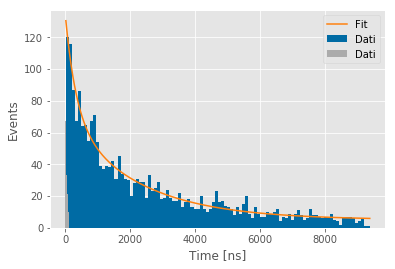

In [638]:
# UTILE
# esegue taglio: taglio soft senza piano uno DOPPIO ESPONENZIALE tau_p fissato
p_merged = soft_cut(data_used)
p_merged_fit = p_merged[(p_merged>19.)&(p_merged<9500)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(complex_expo_fixed, bin_centers, bin_heights, p0=[100.,150.,80.,8.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, complex_expo_fixed(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(complex_expo_fixed(p_merged_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)

print(popt[1]*2197/(2197-popt[1]))
print(np.sqrt((pcov.item(1,1)/popt[1])**2+(270/2197)**2))

plt.legend()
plt.show()

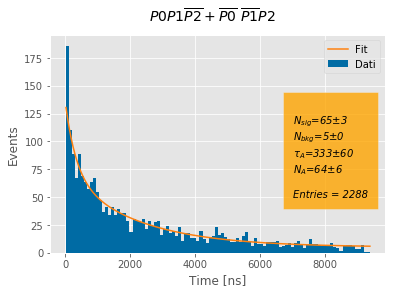

In [639]:
# grafico fit mozzato        N_A,tau_A,N_sig,N_bkg
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, complex_expo_fixed(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50,'\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i\n' r'$\tau_{A} $' '=%i$\pm$%i''\n$N_{A}$' '=%i$\pm$%i''\n\nEntries = %i'%(popt[2],np.sqrt(pcov.item((2,2))),popt[3],np.sqrt(pcov.item((3,3))),popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/soft_doubleexp_fixed.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 1930
Events_fit: 1860
[ 7.43637478e+01  8.30962693e+02  8.24460578e+03  4.61847786e+06
 -8.22405707e+03]
[[ 4.45307809e+01  5.67280050e+02  4.62071115e+07  2.59211010e+10
  -4.62071549e+07]
 [ 5.67280048e+02  1.85862669e+04  8.85329799e+08  4.96681417e+11
  -8.85330725e+08]
 [ 4.62071114e+07  8.85329800e+08  6.46929283e+13  3.62900813e+16
  -6.46929862e+13]
 [ 2.59211009e+10  4.96681417e+11  3.62900813e+16  2.03572489e+19
  -3.62901138e+16]
 [-4.62071547e+07 -8.85330725e+08 -6.46929862e+13 -3.62901138e+16
   6.46930442e+13]]
136.33145958386575
4511900811.495615
Power_divergenceResult(statistic=896.8946326606391, pvalue=9.151413498618465e-129)
9.440996133269886


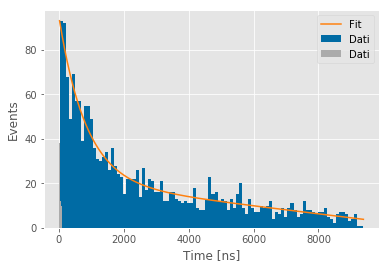

In [620]:
# UTILE
# esegue taglio: taglio hard senza piano uno DOPPIO ESPONENZIALE
p_merged = hard_cut(data_used)
p_merged_fit = p_merged[(p_merged>19.)&(p_merged<10000)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(complex_expo, bin_centers, bin_heights, p0=[100.,200.,86.,2197.,5.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))
print(np.sqrt(pcov.item(3,3)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(complex_expo(p_merged_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)


plt.legend()
plt.show()

In [ ]:
# grafico fit mozzato        N_A,tau_A,N_sig,tau_mu,N_bkg
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i\n' r'$\tau_{A} $' '=%i$\pm$%i''\n$N_{A}$' '=%i$\pm$%i''\n\nEntries = %i'%(popt[3],np.sqrt(pcov.item((3,3))),popt[2],np.sqrt(pcov.item((2,2))),popt[4],np.sqrt(pcov.item((4,4))),popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
plt.savefig('../tesina/plots/hard_doubleexp.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 1930
Events_fit: 1314
[464.75804464 251.39586614  41.25732903   5.39215119]
[[ 4.65470533e+05 -7.20511865e+04  1.30379098e+03 -1.13266703e+02]
 [-7.20511865e+04  1.13800369e+04 -2.31191557e+02  2.05239659e+01]
 [ 1.30379098e+03 -2.31191557e+02  1.15364432e+01 -1.41571888e+00]
 [-1.13266703e+02  2.05239659e+01 -1.41571888e+00  3.19007335e-01]]
106.6772558956101
Power_divergenceResult(statistic=440.3882557673319, pvalue=1.4670035421655502e-44)
4.58737766424304


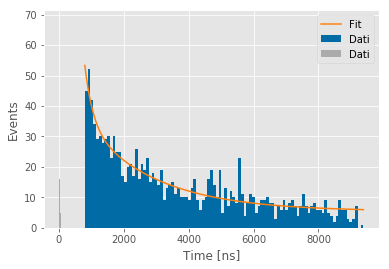

In [603]:
# UTILE
# esegue taglio: taglio hard senza piano uno DOPPIO ESPONENZIALE tau_p fissato
p_merged = hard_cut(data_used)
p_merged_fit = p_merged[(p_merged>800.)&(p_merged<9500)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(complex_expo_fixed, bin_centers, bin_heights, p0=[100.,150.,80.,8.])
print(popt)
print(pcov)

print(np.sqrt(pcov.item(1,1)))

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, complex_expo_fixed(x_interval_for_fit, *popt), label='Fit')

bin_heights_fit, bin_borders_fit, _fit = plt.hist(complex_expo_fixed(p_merged_fit, *popt), bins=100, label='Dati')
chi=chisquare(bin_heights,f_exp=bin_heights_fit)
print(chi)
chi_red = chi[0] / (len(bin_heights_fit)-len(popt))
print(chi_red)

plt.legend()
plt.show()